# US Flights Data 2008 Exploration
## by Shu Liu

## Preliminary Wrangling

The dataset I used for this project reports flights in the United States during the year of 2008 with 7,009,728 records in total, including carriers, airports, arrival and departure delays as well as flight cancellations. By analyzing this data set, I'm trying to answre the following questions:

* In 2008, what are the numbers of flights operated by each carrier and at each airport
* What is the busiest month during the year and the busiest hour during a day?
* How much are flight delayed on average by each carrier at each hour? 
* What are the primary reasons for flight delays by each carrier?  

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

> Load in your dataset and describe its properties through the questions below.
Try and motivate your exploration goals through this section.

In [2]:
flights = pd.read_csv('../input/dataanalystnanodegree/2008.csv')
airports = pd.read_csv('../input/dataanalystnanodegree/airports.csv')[['iata','airport','lat','long']]
airports = airports.add_prefix('Origin_')
airports_dest = pd.read_csv('../input/dataanalystnanodegree/airports.csv')[['iata','airport','lat','long']]
airports_dest = airports_dest.add_prefix('Dest_')
carriers = pd.read_csv('../input/dataanalystnanodegree/carriers.csv')
carriers = carriers.add_prefix('carrier_')
#planes = pd.read_csv('../input/dataanalystnanodegree/plane-data.csv')

In [3]:
df_2008 = pd.merge(flights,airports,left_on='Origin',right_on='Origin_iata')
df_2008 = pd.merge(df_2008,airports_dest,left_on='Dest',right_on='Dest_iata')
df_2008 = pd.merge(df_2008,carriers,left_on='UniqueCarrier',right_on='carrier_Code')

The description of data fields can be found [here](http://stat-computing.org/dataexpo/2009/the-data.html). I'm also posting some of the key information in this notebook for convenience:

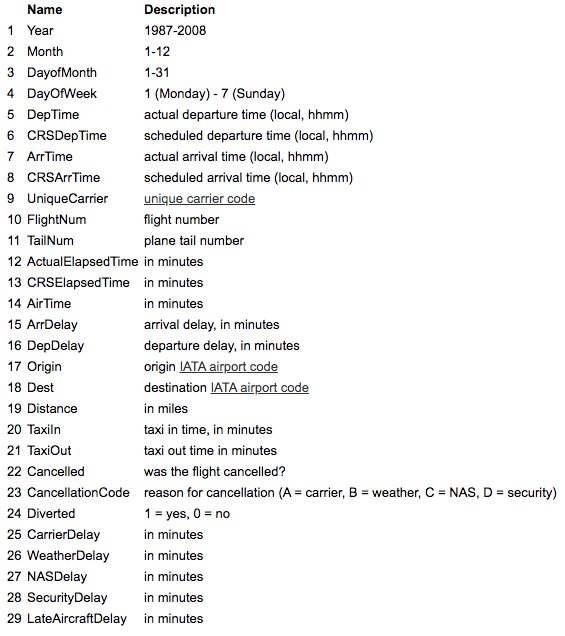

In [4]:
df_2008.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7009728 entries, 0 to 7009727
Data columns (total 39 columns):
 #   Column               Dtype  
---  ------               -----  
 0   Year                 int64  
 1   Month                int64  
 2   DayofMonth           int64  
 3   DayOfWeek            int64  
 4   DepTime              float64
 5   CRSDepTime           int64  
 6   ArrTime              float64
 7   CRSArrTime           int64  
 8   UniqueCarrier        object 
 9   FlightNum            int64  
 10  TailNum              object 
 11  ActualElapsedTime    float64
 12  CRSElapsedTime       float64
 13  AirTime              float64
 14  ArrDelay             float64
 15  DepDelay             float64
 16  Origin               object 
 17  Dest                 object 
 18  Distance             int64  
 19  TaxiIn               float64
 20  TaxiOut              float64
 21  Cancelled            int64  
 22  CancellationCode     object 
 23  Diverted             int64  
 24

In [5]:
# define a function downcast() to reduce the storage size to the least for each column
def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == np.object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]],format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df

In [6]:
# apply the downcast function to the whole dataframe
df_2008 = downcast(df_2008)

In [7]:
df_2008.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7009728 entries, 0 to 7009727
Data columns (total 39 columns):
 #   Column               Dtype   
---  ------               -----   
 0   Year                 int16   
 1   Month                int8    
 2   DayofMonth           int8    
 3   DayOfWeek            int8    
 4   DepTime              float16 
 5   CRSDepTime           int16   
 6   ArrTime              float16 
 7   CRSArrTime           int16   
 8   UniqueCarrier        category
 9   FlightNum            int16   
 10  TailNum              category
 11  ActualElapsedTime    float16 
 12  CRSElapsedTime       float16 
 13  AirTime              float16 
 14  ArrDelay             float16 
 15  DepDelay             float16 
 16  Origin               category
 17  Dest                 category
 18  Distance             int16   
 19  TaxiIn               float16 
 20  TaxiOut              float16 
 21  Cancelled            int8    
 22  CancellationCode     category
 23  Diverte

In [8]:
# remove rows with null values in DepTime and DepDelay
df_2008.dropna(subset=['DepTime','DepDelay'],inplace=True)

In [9]:
# fix the long string value in carrier_Description 
df_2008.carrier_Description.replace('US Airways Inc. (Merged with America West 9/05. Reporting for both starting 10/07.)','US Airways Inc.',inplace=True)

In [10]:
# fix the time related columns so they are in hhmm format 
df_2008['DepTime'] = df_2008['DepTime'].apply(lambda x: x if pd.isnull(x) else str(int(x)).zfill(4))
df_2008['CRSDepTime'] = df_2008['CRSDepTime'].apply(lambda x: x if pd.isnull(x) else str(int(x)).zfill(4))
df_2008['ArrTime'] = df_2008['ArrTime'].apply(lambda x: x if pd.isnull(x) else str(int(x)).zfill(4))
df_2008['CRSArrTime'] = df_2008['CRSArrTime'].apply(lambda x: x if pd.isnull(x) else str(int(x)).zfill(4))

In [11]:
# add a new column 'Hour' to record the hour of flight departure time 
df_2008['Actual_DepHour'] = df_2008['DepTime'].apply(lambda x: str(x)[:2])
df_2008['CRS_DepHour'] = df_2008['CRSDepTime'].apply(lambda x: str(x)[:2])
df_2008['Actual_ArrHour'] = df_2008['ArrTime'].apply(lambda x: str(x)[:2])
df_2008['CRS_ArrHour'] = df_2008['CRSArrTime'].apply(lambda x: str(x)[:2])

In [12]:
# replace NaN values with 0 in column CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
df_2008.fillna({'CarrierDelay':0,'WeatherDelay':0,'NASDelay':0,'SecurityDelay':0,'LateAircraftDelay':0}, inplace=True)

In [13]:
# segregate long/midium/short-haul flights based on distance
def get_flight_length(x):
    if x<=800:
        return 'Short haul'
    elif x >=2600:
        return 'Long haul'
    else:
        return 'Medium haul'
    
df_2008['FlightLen'] = df_2008['Distance'].apply(get_flight_length)

In [14]:
df_2008.shape

(6873482, 44)

In [15]:
df_2008.sample(5).T

,3182714,5132665,2895596,5750668,6360784
Year,2008,2008,2008,2008,2008
Month,1,3,4,5,6
DayofMonth,10,29,9,27,2
DayOfWeek,4,6,3,2,1
DepTime,1645,1732,1553,1036,0535
CRSDepTime,1645,1506,1555,1015,0540
ArrTime,1729,1842,1733,1203,0626
CRSArrTime,1713,1640,1730,1135,0625
UniqueCarrier,OH,9E,DL,MQ,OO
FlightNum,5699,3757,1286,4805,6407


### What is the structure of your dataset?

> The dataset is about flight records in the year of 2008. Each row represents a record of a one-way flight, and each column represents a feature of this flight. There are in total 6,873,482 flight records with 44 features. 

### What is/are the main feature(s) of interest in your dataset?

> Flight delays and cancellations at different airports, by different carriers, and at different time.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

> * In terms of delays and cancellation: ArrDelay, DepDelay, Cancelled
> * In terms of location: Origin & Dest
> * In terms of time: Month, DayOfWeek, DepTime, ArrTime
> * In terms of carrier: UniqueCarrier

## Univariate Exploration

### How many flights do each carrier fly during 2008?

Text(0.5, 1.0, 'Number of Flights of Each Carrier in 2008')

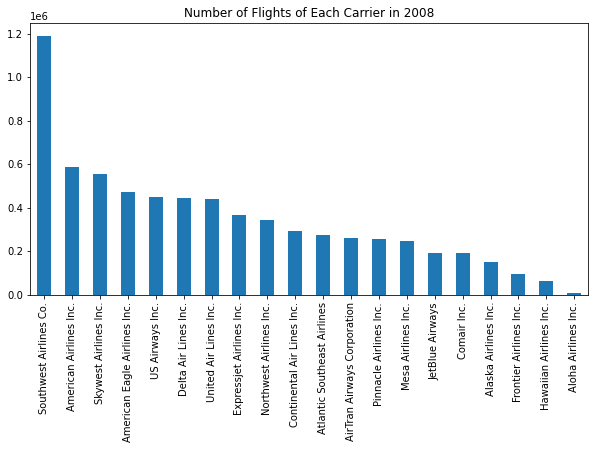

In [16]:
plt.figure(figsize=(10,5))
df_2008.carrier_Description.value_counts().plot(kind='bar').set_title('Number of Flights of Each Carrier in 2008')

The airline company that flied the most number of flights in 2008 turns out to be Southwest Airlines.
### Which airport has the most departure flights in 2008?

Text(0.5, 1.0, 'Top 20 Busiest Airports in 2008')

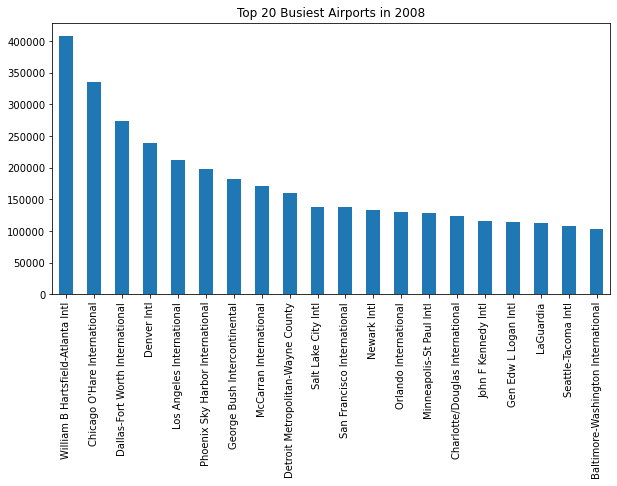

In [17]:
plt.figure(figsize=(10,5))
df_2008.Origin_airport.value_counts()[:20].plot(kind='bar').set_title('Top 20 Busiest Airports in 2008')

The busiest airport in 2008 is William B Hartsfield-Atlanta International airport, and the second and third busiest airports are Chicago O'Hare airport and Dallas-Fort Worth airport. 

### How many flights in each month during 2008?

Text(0.5, 1.0, 'Number of Flights Each Month in 2008')

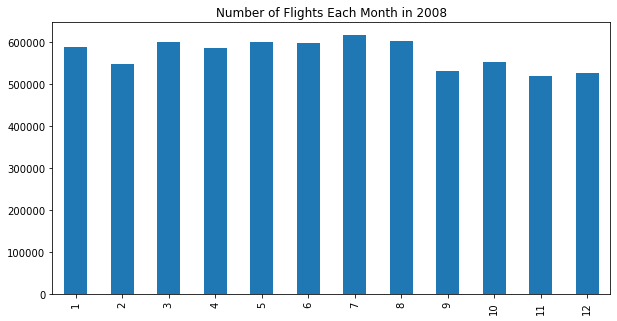

In [18]:
plt.figure(figsize=(10,5))
df_2008.Month.value_counts().sort_index().plot(kind='bar').set_title('Number of Flights Each Month in 2008')

July is the busiest month of the whole year in 2008.

### Which day of the week is generally the busiest?

Text(0.5, 1.0, 'Number of Flights Each Day of Week in 2008')

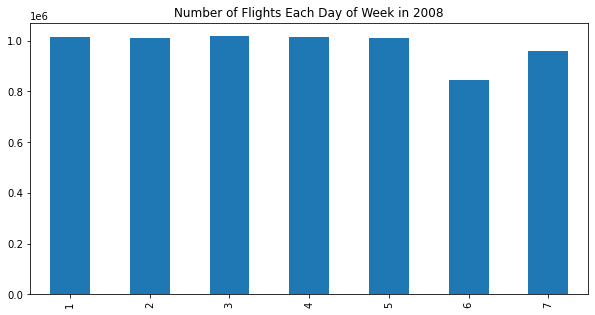

In [19]:
plt.figure(figsize=(10,5))
df_2008.DayOfWeek.value_counts().sort_index().plot(kind='bar').set_title('Number of Flights Each Day of Week in 2008')

There is an obvious drop in the number of flights on weekends compared to weekdays. I think this indicates that business flights contribute to a very large portion of all flights in general.

### What hour of a day is the busiest?

Text(0.5, 1.0, 'Number of Flights During Each Hour of A Day in 2008')

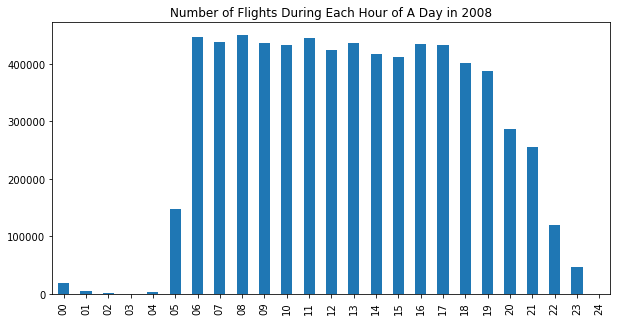

In [20]:
plt.figure(figsize=(10,5))
df_2008.Actual_DepHour.value_counts().sort_index().plot(kind='bar').set_title('Number of Flights During Each Hour of A Day in 2008')

From the above we can see 6AM-8AM are usually the busiest hours during a day. And then around 11AM and 5-6PM are two other busy time for airports.
### How often are flights to be cancelled?

Text(0.5, 1.0, 'Flight Cancellation % 2008')

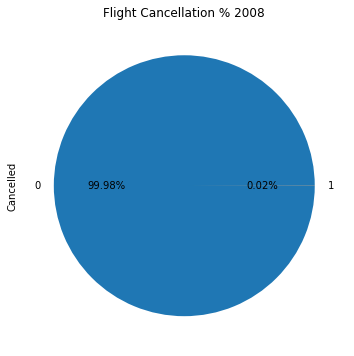

In [21]:
plt.figure(figsize=(10,6))
df_2008.Cancelled.value_counts().plot(kind='pie',autopct='%.2f%%').set_title('Flight Cancellation % 2008')

There are in total 1,188 flight cancellation in 2008, takes up only 0.02%.

### What's the most common reason that a flight is cancelled?

Text(0.5, 1.0, 'Flight Cancellation Reasons % 2008')

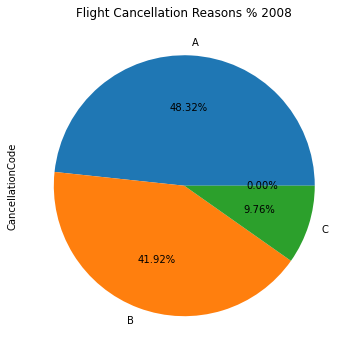

In [22]:
plt.figure(figsize=(10,6))
df_2008.CancellationCode.value_counts().plot(kind='pie',autopct='%.2f%%').set_title('Flight Cancellation Reasons % 2008')

Surprisingly the number of flights cancelled due to carrier reason is larger than the number of weather caused cancellation. 

### How much are flights delayed in general?

In [23]:
print('Percentage of flights that are delayed: {:.2%}\n'.format(len(df_2008.query('DepDelay>0'))/len(df_2008)))
print(df_2008.DepDelay.describe())

Percentage of flights that are delayed: 39.30%

count    6873482.0
mean           NaN
std            NaN
min         -534.0
25%           -4.0
50%           -1.0
75%            8.0
max         2468.0
Name: DepDelay, dtype: float64


In [24]:
x_min = df_2008.DepDelay.quantile(0.01)
x_max = df_2008.DepDelay.quantile(0.99)
df_2008 = df_2008.query('DepDelay>=@x_min and DepDelay<=@x_max')

(-12.0, 164.0)

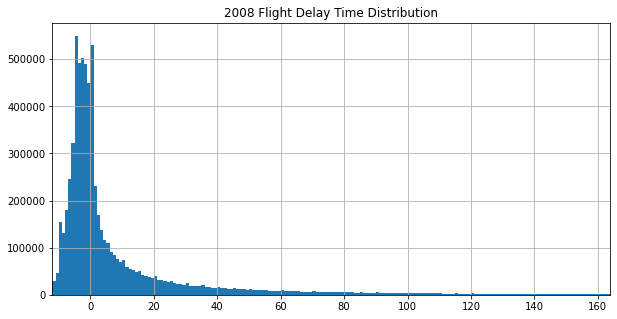

In [25]:
plt.figure(figsize=(10,5))
step = 1
x_min = df_2008.DepDelay.min()
x_max = df_2008.DepDelay.max()
bins = np.arange(x_min-step,x_max+step,step)
df_2008.DepDelay.hist(bins=bins).set_title('2008 Flight Delay Time Distribution')
plt.xlim(x_min,x_max)

Overall there are less than 40% flights delayed in 2008. I noticed there are some extreme early flight (almost 10 hours advanced) and delay flight (more than 41 hours). I did not drop the extreme values, and decided to do this adjustment only when needed. Than I plot a hist graph of the rest of data. The majority of flights are between -12 and 25 minutes from the scheduled departure time.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> There are a few extreme data points from the flight delay time. And I removed the values in column DepDelay that are either lower than 1 percentile or higher than 99 percentile.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> I adjusted the time related columns so they are in hhmm format with length of 4. And I created new columns CRS_DepHour and Actual_DepHour to reflect the hour of scheduled and actual flight departure time.

## Bivariate Exploration

### What's the relationship between number of departure flights, DepDelay, ArrDelay and cancellation at each airport?

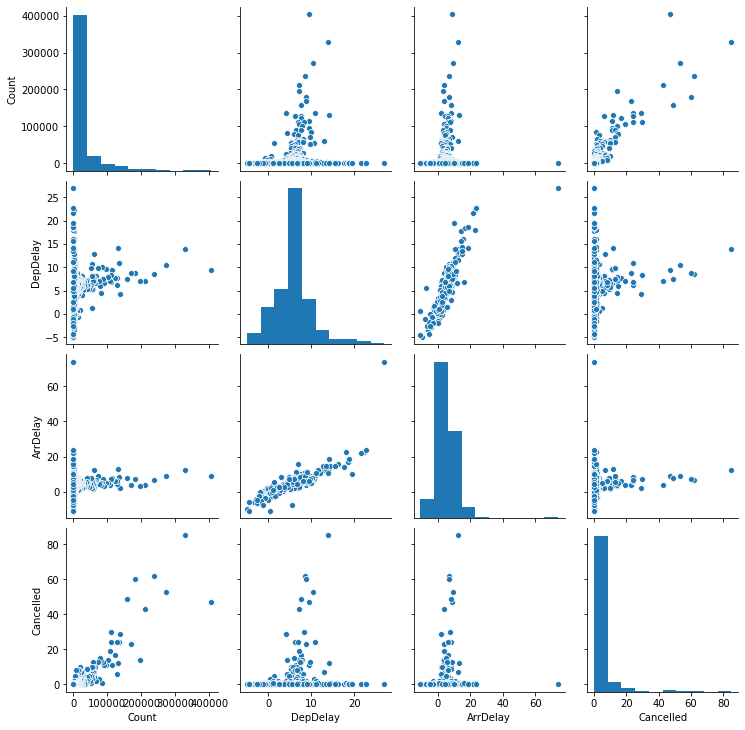

In [26]:
df_airport = df_2008.groupby('Origin_airport').agg({'Year':'count','DepDelay':'mean','ArrDelay':'mean','Cancelled':'sum'}).sort_values('Year', ascending=False)
df_airport.rename(columns={'Year':'Count'}, inplace=True)
sns.pairplot(df_airport)

DepDelay and ArrDelay look to have a very strong positive relationship, which indicates if the more a flight is delayed at departure, the more likely that arrival will be delayed and vice versa. There is also somewhat positive relationship between number of total flights and cancellation. Though this trend isn't as obvious as the relationship between arrival and departure delay time.

There isn't a clear relationship between arrival/depature delay and number of flights. I think this is because different airports have different levels of capability to handle flight traffic. Thus less number of flights at an airport doesn't necessarily mean less cases of flight delays.

### Which airline company has the longest depature/arrival delays?

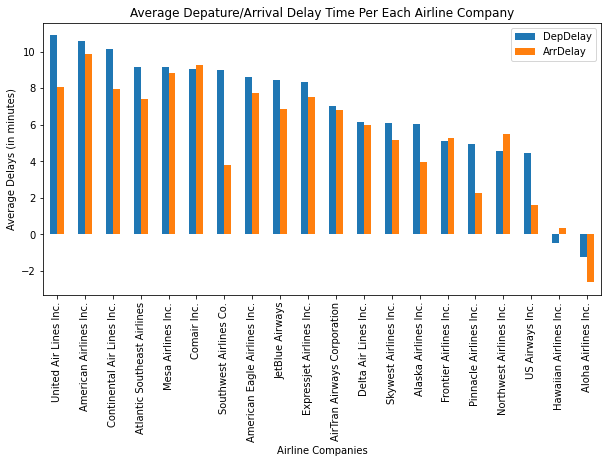

In [27]:
df_airline = df_2008.groupby('carrier_Description').agg({'DepDelay':'mean','ArrDelay':'mean'}).sort_values('DepDelay',ascending=False)
df_airline.plot(kind='bar',figsize=(10,5))
plt.title('Average Depature/Arrival Delay Time Per Each Airline Company')
plt.xlabel('Airline Companies')
plt.ylabel('Average Delays (in minutes)');

In [28]:
df_2008[df_2008.carrier_Description=='Aloha Airlines Inc.'].DepDelay.describe()

count    7478.000000
mean       -1.214844
std        11.484375
min       -12.000000
25%        -6.000000
50%        -4.000000
75%         0.000000
max       150.000000
Name: DepDelay, dtype: float64

United Airlines has the longest average departure delays, and American Airlines has the longest average arrival delays. On the opposite side, flights with Aloha Airlines are advanced on average. I took a further look and it turns out more than 75% of the time Aloha Airlines fly planes earlier than CRS schedule.

### At what hour do people mostly likely to experience the worst flight delays?

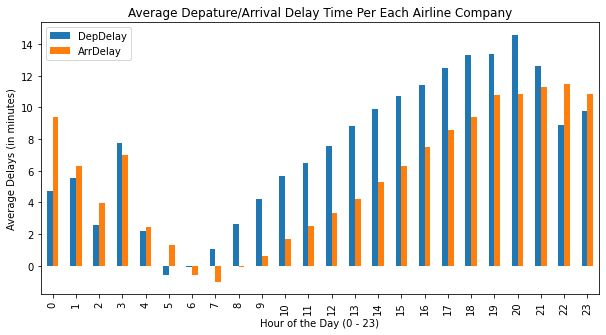

In [29]:
df_dep = df_2008.groupby('CRS_DepHour').agg({'DepDelay':'mean'}).sort_values('CRS_DepHour',ascending=True).reset_index()
df_arr = df_2008.groupby('CRS_ArrHour').agg({'ArrDelay':'mean'}).sort_values('CRS_ArrHour',ascending=True)
df_arr = df_arr[df_arr.index != '24']

df_delays = pd.merge(df_dep,df_arr,left_on='CRS_DepHour',right_on='CRS_ArrHour')
df_delays.plot(kind='bar',figsize=(10,5))
plt.title('Average Depature/Arrival Delay Time Per Each Airline Company')
plt.xlabel('Hour of the Day (0 - 23)')
plt.ylabel('Average Delays (in minutes)');

From 6AM to 8PM there is a gradual increase in the average departure delay time per hour. I think this is because if there are flights delayed in the previous hour, the flight departure schedule in the next hour will be disrupted as a result. So the flight delay situation will aggregate over time. Then during midnight hours since airports generally schedule less flight departure, the trend does down evetually.

There is a similar trend for the arrival time, yet the arrival delay trend is lagged compared to the departure delay trend. I believe this lag is in alignment with time it takes for a plane to fly between two locations.

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

* Observation 1:
> DepDelay and ArrDelay look to have a very strong positive relationship, which indicates if the more a flight is delayed at departure, the more likely that arrival will be delayed and vice versa. There is also somewhat positive relationship between number of total flights and cancellation. Though this trend isn't as obvious as the relationship between arrival and departure delay time.
* Observation 2:
> There isn't a clear relationship between arrival/depature delay and number of flights. I think this is because different airports have different levels of capability to handle flight traffic. Thus less number of flights at an airport doesn't necessarily mean less cases of flight delays.

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

* Observation 3:
> United Airlines has the longest average departure delays, and American Airlines has the longest average arrival delays. On the opposite side, flights with Aloha Airlines are advanced on average. I took a further look and it turns out more than 75% of the time Aloha Airlines fly planes earlier than CRS schedule.
* Observation 4:
> From 6AM to 8PM there is a gradual increase in the average departure delay time per hour. I think this is because if there are flights delayed in the previous hour, the flight departure schedule in the next hour will be disrupted as a result. So the flight delay situation will aggregate over time. Then during midnight hours since airports generally schedule less flight departure, the trend does down evetually. There is a similar trend for the arrival time, yet the arrival delay trend is lagged compared to the departure delay trend. I believe this lag is in alignment with time it takes for a plane to fly between two locations.

## Multivariate Exploration
### What's the biggest reason for departure delay at each airport?


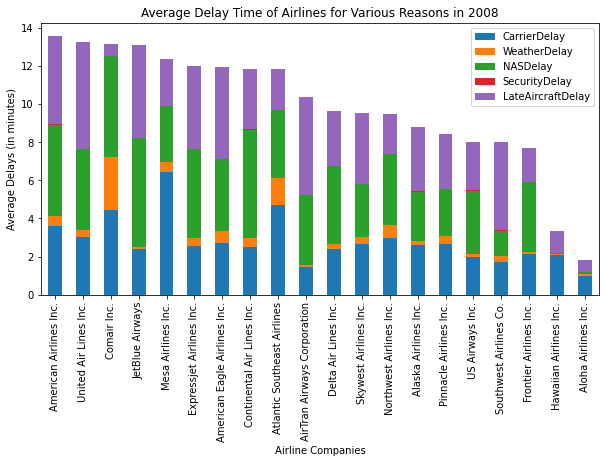

In [30]:
df_airport = df_2008.groupby('carrier_Description').agg({'DepDelay':'mean','CarrierDelay':'mean','WeatherDelay':'mean','NASDelay':'mean','SecurityDelay':'mean','LateAircraftDelay':'mean'})
df_airport['total'] = df_airport.iloc[:,1:6].sum(axis=1)
df_airport = df_airport.sort_values('total', ascending=False)
df_airport[['CarrierDelay','WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay']].plot(kind="bar",stacked=True,figsize=(10,5)).set_title('Average Delay Time of Airlines for Various Reasons in 2008')
plt.xlabel('Airline Companies')
plt.ylabel('Average Delays (in minutes)');

For most of airline companies, the two biggest reasons for flight delay are late aircraft delay and NAS delay. On the other hand, airline companies like Comair, Mesa Airlines and Atlantic Southeast Airlines, the top two reasons are carrier delay and weather delay.

### What are the top carriers operating long/medium/short haul flights?

In [31]:
df_distance = df_2008.groupby(['FlightLen','carrier_Description'],sort=False)['Year'].agg([('count','count')]).reset_index().sort_values(by=['FlightLen','count'],ascending=[False,False])

Text(0.5, 1.0, 'Long haul')

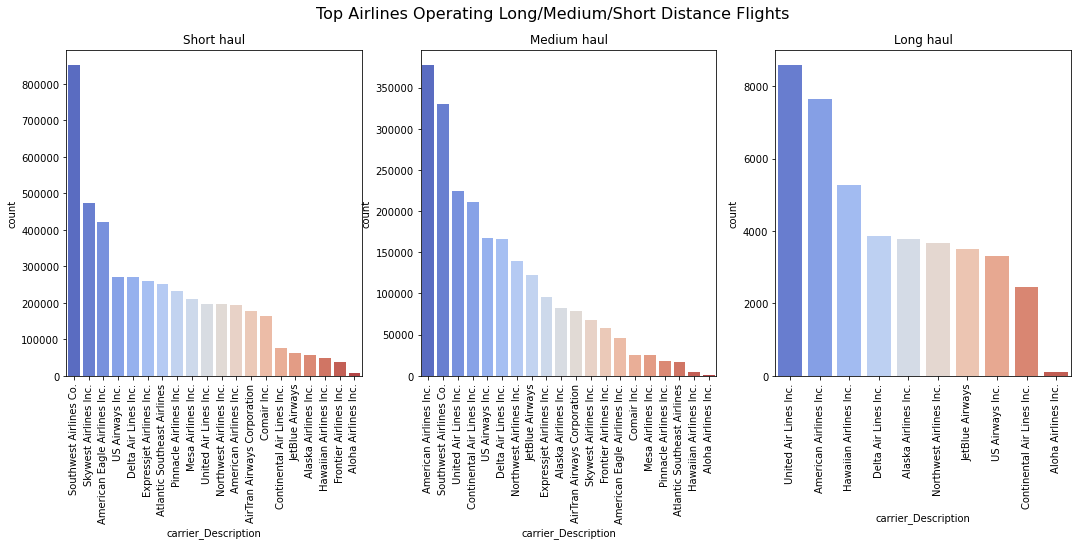

In [32]:
# visualize top 10 neighborhoods per each room type
fig,axes = plt.subplots(nrows=1,ncols=3,sharey=False,sharex=False,figsize=(18,6))
fig.suptitle('Top Airlines Operating Long/Medium/Short Distance Flights', fontsize=16)
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)
data1 = df_distance[df_distance['FlightLen']=='Short haul'].sort_values('count',ascending=False)
plot_order1 = data1.carrier_Description.values
sns.barplot(x='carrier_Description',y='count',data=data1,ax=axes[0],palette='coolwarm',order=plot_order1)
axes[0].set_title('Short haul')
data2 = df_distance[df_distance['FlightLen']=='Medium haul'].sort_values('count',ascending=False)
plot_order2 = data2.carrier_Description.values
sns.barplot(x='carrier_Description',y='count',data=data2,ax=axes[1],palette='coolwarm',order=plot_order2)
axes[1].set_title('Medium haul')
data3 = df_distance[(df_distance['FlightLen']=='Long haul')&(df_distance['count']>0)].sort_values('count',ascending=False)
plot_order3 = data3.carrier_Description.values
sns.barplot(x='carrier_Description',y='count',data=data3,ax=axes[2],palette='coolwarm',order=plot_order3)
axes[2].set_title('Long haul')

Top 3 carriers for short distance flights (<800 miles) are Southwest, Skywest, and American Eagle airlines. Top carriers for medium distance flights (between 800 and 2600 miles) are American Airlines, Southwest and United Airlines. There are relatively fewer airline companies operating long distance flights (>2600 miles), and the top 3 are United, American and Hawaiian airlines.

### What do the delays typically look like for different flight distance?

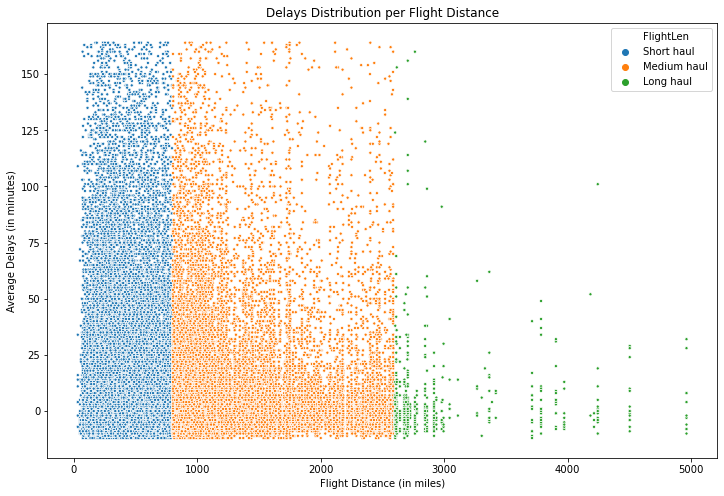

In [33]:
plt.figure(figsize=(12,8))
sns.scatterplot(data=df_2008.sample(100000).sort_values(by='FlightLen',ascending=False),x='Distance',y='DepDelay',hue='FlightLen',s=10).set_title('Delays Distribution per Flight Distance')
plt.title('Delays Distribution per Flight Distance')
plt.xlabel('Flight Distance (in miles)')
plt.ylabel('Average Delays (in minutes)');

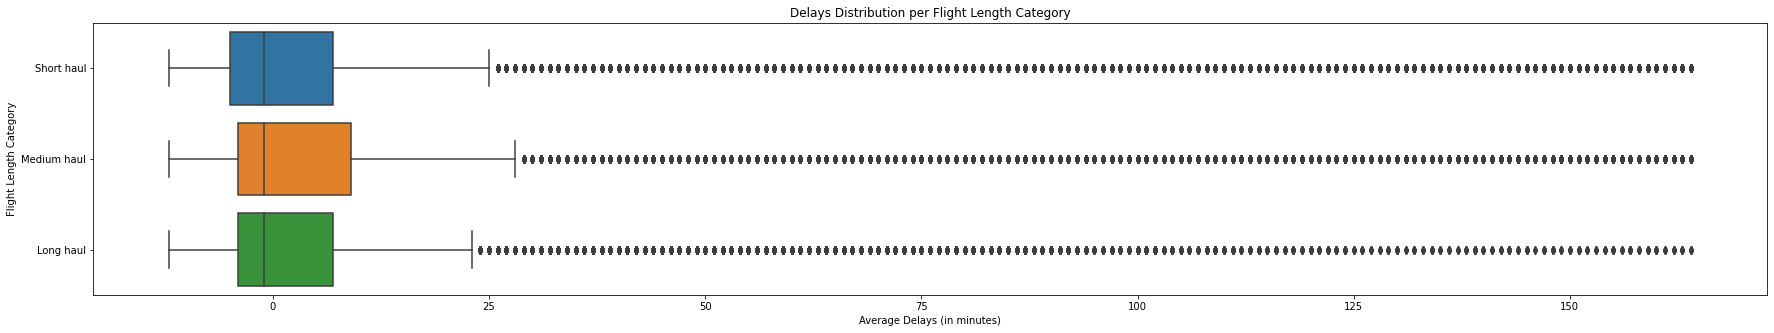

In [34]:
plt.figure(figsize=(30,5))
sns.boxplot(data=df_2008.sort_values(by='FlightLen',ascending=False),y='FlightLen',x='DepDelay')
plt.title('Delays Distribution per Flight Length Category')
plt.xlabel('Average Delays (in minutes)')
plt.ylabel('Flight Length Category');

In [35]:
# Flight delays percentile statistics per each flight length category
print(df_2008.groupby(['FlightLen']).DepDelay.describe())

                 count  mean   std   min  25%  50%  75%    max
FlightLen                                                     
Long haul      42169.0   inf  24.0 -12.0 -4.0 -1.0  7.0  164.0
Medium haul  2254196.0   NaN   0.0 -12.0 -4.0 -1.0  9.0  164.0
Short haul   4457557.0   NaN   0.0 -12.0 -5.0 -1.0  7.0  164.0


In [36]:
delay = df_2008.query('DepDelay>0').groupby(['FlightLen'])['DepDelay'].agg([('Count of Delayed Flights','count')]).reset_index()
total = df_2008.groupby(['FlightLen'])['DepDelay'].agg([('Total Count of Flights','count')]).reset_index()
delay = pd.merge(left=delay,right=total,left_on='FlightLen',right_on='FlightLen')
delay['Delay Ratio %'] = np.round(delay['Count of Delayed Flights']/delay['Total Count of Flights']*100,2)
print('Percent of Flight Delays for Different Flight Length:\n',delay[['FlightLen','Count of Delayed Flights','Delay Ratio %']]);

Percent of Flight Delays for Different Flight Length:
      FlightLen  Count of Delayed Flights  Delay Ratio %
0    Long haul                     17273          40.96
1  Medium haul                    966446          42.87
2   Short haul                   1649409          37.00


Short distance flights have the largest numbr of delays, while medium distance flight has the highest portion of delays out of all flights.
### What's the flight traffic like at each airport? (adding up both departure and arrival)

In [37]:
df_dep = df_2008.groupby('Origin').agg({'Year':'count','Origin_long':'mean','Origin_lat':'mean'}).reset_index()
df_dep.rename(columns={'Origin':'Airport','Year':'Count','Origin_long':'long','Origin_lat':'lat'}, inplace=True)
df_arr = df_2008.groupby('Dest').agg({'Year':'count','Dest_long':'mean','Dest_lat':'mean'}).reset_index()
df_arr.rename(columns={'Dest':'Airport','Year':'Count','Dest_long':'long','Dest_lat':'lat'}, inplace=True)
df_combine = pd.concat([df_dep,df_arr],ignore_index=True)
df_combine = df_combine.groupby('Airport').agg({'Count':'sum','long':'mean','lat':'mean'}).reset_index()

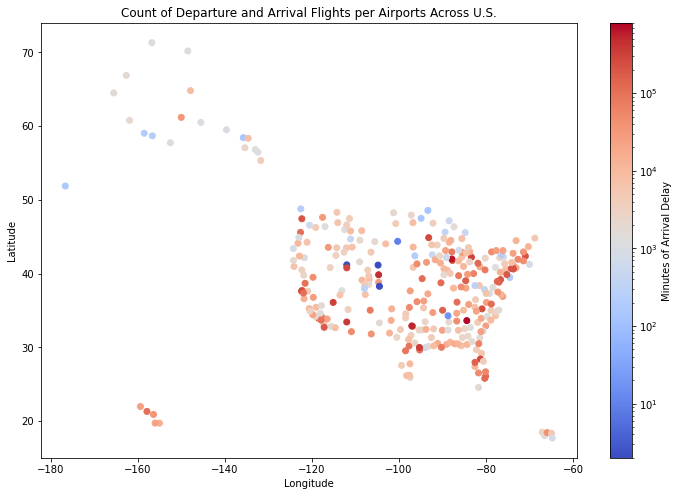

In [38]:
plt.figure(figsize=(12,8))
g = plt.scatter(x=df_combine.long,y=df_combine.lat,c=df_combine.Count,cmap=plt.get_cmap('coolwarm'),norm=matplotlib.colors.LogNorm())
plt.colorbar(g).set_label('Minutes of Arrival Delay')
plt.title('Count of Departure and Arrival Flights per Airports Across U.S.')
plt.xlabel('Longitude')
plt.ylabel('Latitude');

Flight traffic, including both departure and arrival, of each airport on a heatmap in the shape of US map. Each dot represents the approximation of the location of an airport. The warmer ('reder) the color, the heavier traffic.
One issue noticed is that the arrival 
### Flight delays on a map?

In [39]:
class MidpointNormalize(matplotlib.colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return np.ma.masked_array(np.interp(value, x, y))

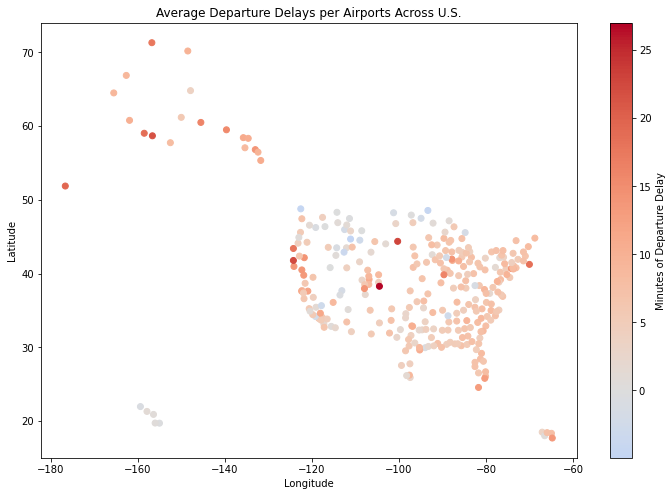

In [40]:
df_delay = df_2008.groupby('Origin').agg({'DepDelay':'mean','Origin_long':'mean','Origin_lat':'mean'}).reset_index()

plt.figure(figsize=(12,8))
vmin = df_delay.DepDelay.min()
vmax = df_delay.DepDelay.max()
norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=0)
cmap = plt.get_cmap('coolwarm')

g = plt.scatter(x=df_delay.Origin_long,y=df_delay.Origin_lat,c=df_delay.DepDelay,cmap=cmap,norm=norm)
plt.colorbar(g).set_label('Minutes of Departure Delay')
plt.title('Average Departure Delays per Airports Across U.S.')
plt.xlabel('Longitude')
plt.ylabel('Latitude');

Average departure delays of each airport on a heatmap in the shape of US map. Each dot represents the approximation of the location of an airport.. The warmer ('reder) the color, the more delayed is a flight on average in that airport.

## Save Data

In [41]:
df_2008.columns
df_2008.drop(columns=['FlightNum','TailNum','ActualElapsedTime','CRSElapsedTime','AirTime','TaxiIn','TaxiOut','Diverted','Origin_iata','Dest_iata','carrier_Code','Dest_airport'],axis=1,inplace=True)

In [42]:
df_2008.to_csv('2008_clean_master_file.csv', index=False)

## Reference

How to set midpoint for colormap: https://stackoverflow.com/questions/7404116/defining-the-midpoint-of-a-colormap-in-matplotlib